# Import des Data

In [2]:
import pandas as pd

In [1]:
chanel_5k = pd.read_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_5k.csv",sep=";", error_bad_lines=False)
chanel = chanel_5k[chanel_5k['language'] == 'en']['text'].tolist()
publication_time_chanel = chanel_5k[chanel_5k['language'] == 'en']['publication_time'].tolist()
len(chanel)

C:\Users\a.tekiouk\AppData\Local\Temp\ipykernel_4488\3904026442.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chanel_5k = pd.read_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_5k.csv",sep=";", error_bad_lines=False)


2285

# Modification de la pipe

In [9]:
import numpy as np
import spacy

nlp = spacy.load("en_core_web_sm")

from spacymoji import Emoji


nlp.add_pipe("emoji", first=True)

In [10]:
import spacy 
from spacy.vocab import Vocab
from spacy.language import Language
from spacy.tokens import Token


@Language.component("hashtag")
def hashtag_pipe(doc):
    merged_hashtag = False
    while True:
        for token in doc:
            if token.text == '#':
                if token.head is not None:
                    start_index = token.i
                    end_index = start_index + 1
                    with doc.retokenize() as retokenizer:
                        retokenizer.merge(doc[start_index:end_index+1])
                        merged_hashtag = True
                        break
        if not merged_hashtag:
            break
        merged_hashtag = False
    return doc


In [11]:
nlp.add_pipe("hashtag", first=True)
hashtag_getter = lambda token: token.text[0] in ("#")
Token.set_extension("is_hashtag", getter=hashtag_getter, force=True)

# Métohdes

In [55]:
def clean_right_side(df):
        for i in range(len(df['text'])):
            if(df['text'][i][-1]=="#"):
                df['text'][i] = df['text'][i].rstrip(df['text'][i][-1])

In [100]:
def top_hashtags(text, top):
    hashtag = []
    for i in text:
        doc = nlp(i)
        for token in doc:
            if token._.is_hashtag:
                hashtag.append(token.text)
    Hashtag_corpus = pd.DataFrame()
    Hashtag_corpus['hashtag'] = hashtag
    Hashtag_corpus2 = Hashtag_corpus.groupby("hashtag").size()
    return Hashtag_corpus2.nlargest(top).tail(top)

In [109]:
def top_emojis(text, top):
    emoji = []
    for i in text:
        doc = nlp(i)
        for token in doc:
            if token._.is_emoji:
                emoji.append(token.text)
    Emoji_corpus = pd.DataFrame()
    Emoji_corpus['emoji'] = emoji
    Emoji_corpus2 = Emoji_corpus.groupby("emoji").size()
    print(Emoji_corpus2.nlargest(top))

In [111]:
def dummy_hashtags(df, top):
    hashtag = []
    for i in df['text']:
        doc = nlp(i)
        for token in doc:
            if token._.is_hashtag:
                hashtag.append(token.text)
    Hashtag_corpus = pd.DataFrame()
    Hashtag_corpus['hashtag'] = hashtag
    Hashtag_corpus2 = Hashtag_corpus.groupby("hashtag").size().nlargest(top).tail(top)
    df_hash = pd.DataFrame(Hashtag_corpus2.index)
    print(df_hash)
    j=0
    for e in df_hash['hashtag']:
        dummy = []
        for t in df['text']:
            if(e in t):
                dummy.append(1)
            else:
                dummy.append(0)
        df['has_hash_'+str(j)] = dummy
        j=j+1

In [112]:
def dummy_emojis(df,top):
    emoji = []
    for i in df['text']:
        doc = nlp(i)
        for token in doc:
            if token._.is_emoji:
                emoji.append(token.text)
    Emoji_corpus = pd.DataFrame()
    Emoji_corpus['emoji'] = emoji
    Emoji_corpus2= pd.DataFrame(Emoji_corpus.groupby("emoji").size().nlargest(top).tail(top))
    df_emo = pd.DataFrame(Emoji_corpus2.index)
    j=0
    for e in df_emo['emoji']:
        dummy = []
        for t in df['text']:
            if(e in t):
                dummy.append(1)
            else:
                dummy.append(0)
        df['has_emo_'+str(j)] = dummy
        j=j+1

In [46]:
def word_ratio(df):
    ratio = []
    for i in df['text']:
        doc = nlp(i)
        nb_word = 0
        nb_hash = 0
        for token in doc:
            if(token._.is_hashtag):
                nb_hash+=1
            else:
                nb_word+=1
        if((nb_hash+nb_word)!=0):
            ratio.append(nb_word/(nb_hash+nb_word))
        else:
            ratio.append(0)  
    df['ratio_word'] = ratio

In [48]:
def caps_ratio(df):
    ratio = []
    for i in df['text']:
        doc = nlp(clean_hashtag(i))
        nb_lower = 0
        nb_caps = 0
        for token in doc:
            if(token.text.isupper()):
                nb_caps+=1
            else:
                nb_lower+=1
        if((nb_caps+nb_lower)!=0):
            ratio.append(nb_caps/(nb_caps+nb_lower))
        else:
            ratio.append(1)
    df['ratio_caps'] = ratio

In [17]:
import re

def clean_hashtag(t): #--text
    hashtag_pattern= re.compile("#[A-Za-z0-9_]+")
    return re.sub(hashtag_pattern,"", t) #On supprime tout les types de #


def del_double(txt,publication_time,s,method): # --text --liste des date et heure de publication pour chaque élément de la liste --seuil (s dans [0;1] ou [0;100] selon la méthode) --méthode
    t = txt.copy()
    distance = method #initialisiation de levenshtein avec la distance normalisée.
    i = 0
    r = len(t)
    while(i<r):
        r = len(t)
        j=i+1
        while(j<r):
            if(distance(clean_hashtag(t[i]).strip(),clean_hashtag(t[j]).strip()) <= s ): # Si la distance entre les deux élemens de la liste inf à seuil
                if(publication_time[i]<publication_time[j]):
                    del t[j] #delete
                    r = len(t) #on actualise la taille de la listes
                else:
                    del t[i]
                    r = len(t) #on actualise la taille de la listes
            else:
                j+=1
        i+=1
    return t

# Creation d'un sample de validation

In [11]:
import random
chanel_junk_valid = random.choices(chanel, k=700)

NameError: name 'chanel' is not defined

In [17]:
import textdistance
dist = textdistance.levenshtein.normalized_distance
chanel_junk_valid_dd = del_double(chanel_junk_valid,publication_time_chanel,0.5,dist)

In [18]:
len(chanel_junk_valid_dd)

207

In [19]:
chanel_junk_valid_df= pd.DataFrame()
chanel_junk_valid_df['text'] = chanel_junk_valid_dd

In [20]:
chanel_junk_valid_df.to_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_junk_valid.csv")
# Ajout de la variable is_junk sur excel

### Sample de validation : 

In [49]:
chanel_junk_valid_new = pd.read_excel('C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_junk_valid_new.xlsx')
chanel_junk_valid_new = chanel_junk_valid_new[['text','is_junk']]

In [50]:
chanel_junk_valid_new.head()

,text,is_junk
0,The camelia - a long time symbol of Chanel and...,0
1,Wknds are my happy place 🤍 even if they do inc...,1
2,Used Card holder XL 24999.-\n\nLine: 244xfzmn,1
3,My love for a chanelofficial classic flap 😌| #...,0
4,HAPPY BIRTHDAY KING KUMA\n\nJENNIE #SOLO STAGE...,1


In [51]:
clean_right_side(chanel_junk_valid_new)

C:\Users\a.tekiouk\AppData\Local\Temp\ipykernel_72028\4264421119.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i] = df['text'][i].rstrip(df['text'][i][-1])


,text,is_junk
0,The camelia - a long time symbol of Chanel and...,0
1,Wknds are my happy place 🤍 even if they do inc...,1
2,Used Card holder XL 24999.-\n\nLine: 244xfzmn,1
3,My love for a chanelofficial classic flap 😌| #...,0
4,HAPPY BIRTHDAY KING KUMA\n\nJENNIE #SOLO STAGE...,1
...,...,...
202,"I am a brand wholesaler, DHL and Federal world...",1
203,#香奈儿 #爱马仕 #lv #birkin #gucci #hermes #kelly #l...,1
204,#chanel #chanelarchive #2008 #chaneldress #hau...,1
205,"Hello, what are you doing today ? Tell me ! En...",1


# Ajout de features

### Ratio de mot

In [52]:
word_ratio(chanel_junk_valid_new)

In [53]:
chanel_junk_valid_new.head()

,text,is_junk,ratio_word
0,The camelia - a long time symbol of Chanel and...,0,0.587302
1,Wknds are my happy place 🤍 even if they do inc...,1,0.680851
2,Used Card holder XL 24999.-\n\nLine: 244xfzmn,1,1.000000
3,My love for a chanelofficial classic flap 😌| #...,0,0.562500
4,HAPPY BIRTHDAY KING KUMA\n\nJENNIE #SOLO STAGE...,1,0.310345


### Ratio de caps

In [54]:
caps_ratio(chanel_junk_valid_new)

In [30]:
chanel_junk_valid_new.head()

,text,is_junk,ratio_word,ratio_caps
0,The camelia - a long time symbol of Chanel and...,0,0.587302,0.015873
1,Wknds are my happy place 🤍 even if they do inc...,1,0.680851,0.000000
2,Used Card holder XL 24999.-\n\nLine: 244xfzmn,1,1.000000,0.111111
3,My love for a chanelofficial classic flap 😌| #...,0,0.562500,0.000000
4,HAPPY BIRTHDAY KING KUMA\n\nJENNIE #SOLO STAGE...,1,0.310345,0.344828


### Top hashtags junk

In [ ]:
s = chanel_junk_valid_new[chanel_junk_valid_new['is_junk']==1]['text']

In [93]:
top_hashtags(s,15)

hashtag
#chanel            91
#fashion           29
#style             19
#explorepage       15
#luxury            15
#ootd              15
#dior              14
#gucci             13
#Chanel            12
#louisvuitton      12
#chanellover       11
#fashionblogger    11
#aesthetic         10
#bag               10
#instagood         10
dtype: int64


### Top emojis junk

In [110]:
top_emojis(s,15)

emoji
➖     34
▪     28
🌼     20
✨     16
😍     14
❤     12
🖤     12
🔥     11
❤️    10
🤍      9
🌸      8
🎀      8
✈      7
👉      7
📞      6
dtype: int64


In [108]:
t.shape

(15, 1)

# Correlation, histogramems, boxplot

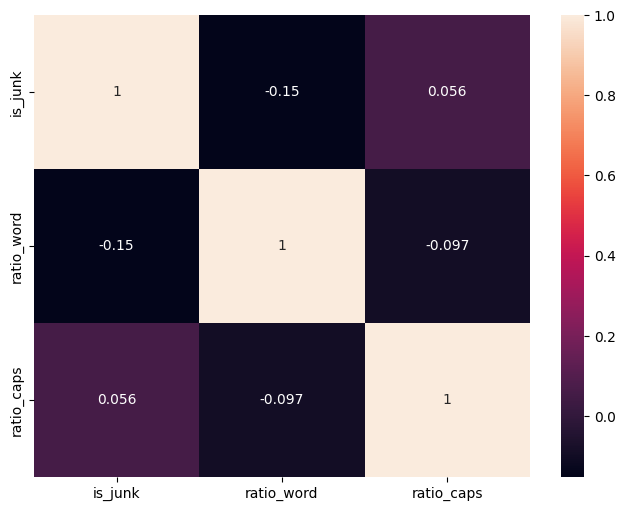

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = chanel_junk_valid_new[['is_junk','ratio_word','ratio_caps']].corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()